In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
from pathlib import Path
import h5py
import scipy.stats
import torch
import pandas as pd
import os

import bnn_priors.plot as plot
import bnn_priors.exp_utils as exp_utils

In [2]:
def flatten(in_dict):
    out_dict = {}
    for k, v in in_dict.items():
        if isinstance(v, dict):
            v_flat = flatten(v)
            out_dict.update({k+"."+v_k: v_v for v_k, v_v in v_flat.items()})
        else:
            out_dict[k] = v
    return out_dict

In [182]:
base_log_dir = Path("/scratches/huygens/ag919/BNN-priors/logs/0_3_cifar10_sgd")

test_accs = []
test_losses = []
steps = None

for run in os.listdir(base_log_dir):
    if run in ["_sources", "jugdir", "mom1"]:
        continue
    with h5py.File(base_log_dir/run/"metrics.h5", "r", swmr=True) as f:
        if steps is None:
            steps = f["steps"][:]
        else:
            assert np.all(steps == f["steps"][:])
        test_accs.append(f["test/acc"][:])
        test_losses.append(f["test/loss"][:])

In [193]:
base_log_dir = Path("/scratches/huygens/ag919/BNN-priors/logs/0_5_lr_cifar10")

series_list = []

for run in os.listdir(base_log_dir):
    if run in ["_sources", "jugdir"]:
        continue
    with open(base_log_dir/run/"run.json") as f:
        s2 = pd.Series(flatten(json.load(f)))
    with open(base_log_dir/run/"config.json") as f:
        s1 = pd.Series(flatten(json.load(f)))
        
    s2["the_dir"] = base_log_dir/run
    series_list.append(pd.concat([s1, s2]))
        
    
df = pd.DataFrame(series_list)
full_df = df[df["status"] == "COMPLETED"]
full_df[["lr", "temperature", "weight_prior", "inference", "log_dir"]]

,lr,temperature,weight_prior,inference,log_dir
0,0.100000,0.01,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_5_l...
3,0.003162,0.01,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_5_l...
4,0.001000,1.00,gaussian,HMCReject,/scratches/huygens/ag919/BNN-priors/logs/0_5_l...
6,0.100000,1.00,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_5_l...
8,0.010000,1.00,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_5_l...
11,0.000316,0.01,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_5_l...
13,0.010000,0.01,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_5_l...
21,0.010000,1.00,gaussian,HMCReject,/scratches/huygens/ag919/BNN-priors/logs/0_5_l...
22,0.000316,1.00,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_5_l...
24,0.000316,1.00,gaussian,HMCReject,/scratches/huygens/ag919/BNN-priors/logs/0_5_l...


## Create model class

First we create the model class used in the run. Used in the metrics to know the sizes of the parameters.

In [33]:
with open(Path(completed_df.iloc[0, :]["the_dir"])/"config.json", "r") as f:
    config = json.load(f)

device = torch.device("cpu")  # can be CUDA instead
data = exp_utils.get_data(config["data"], device)
model = exp_utils.get_model(x_train=data.norm.train_X, y_train=data.norm.train_y,
                            **{k: v for k, v in config.items() if k in set((
                               "model",
                               "width", "depth", "weight_prior", "weight_loc", "weight_scale",
                               "bias_prior", "bias_loc", "bias_scale", "batchnorm",
                               "weight_prior_params", "bias_prior_params"))})

print(f"Loaded model of kind {config['model']}")
config["temperature"]

Loaded model of kind thin_resnet18


1.0

In [34]:
config["temperature"], config["lr"]

(1.0, 0.001)

In [35]:
sizes = plot.get_sizes(model)


## Plot metrics

First we load the metrics, then we plot various aspects of them.

In [9]:
# Locate the samples and metrics' meta data in disk.
try:
    metrics = h5py.File(log_dir/"metrics.h5", "r", swmr=True)
except OSError as e:
    raise RuntimeError("Perhaps you have to wait 120 seconds for the metrics to begin saving?")
metrics.keys()

<KeysViewHDF5 ['acc', 'acceptance', 'delta_energy', 'est_config_temp', 'est_temperature', 'log_prior', 'loss', 'lr', 'potential', 'preconditioner', 'steps', 'temperature', 'test', 'timestamps', 'total_energy']>

In [10]:
is_sample_mask = mask = (metrics['acceptance/is_sample'][:] == 1)
# This is where the samples have been taken (and accepted or rejected:)

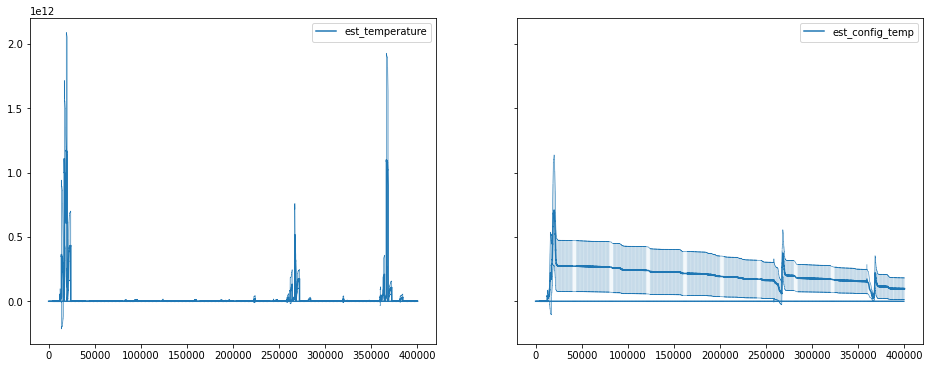

In [12]:
_, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

plot.temperature_stderr(axes[0], metrics, "est_temperature", sizes, ewma_alpha=0.0, mask=slice(None))
#axes[0].set_ylim((-20, 20))
plot.temperature_stderr(axes[1], metrics, "est_config_temp", sizes, ewma_alpha=0.0, mask=slice(None))

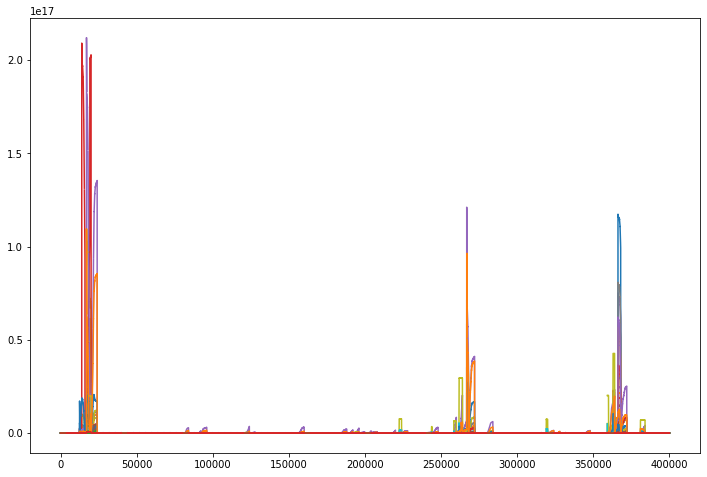

In [14]:
_, ax = plt.subplots(1, 1, figsize=(12, 8))


for k in metrics["est_temperature"].keys():
    if k == "all":
        continue
    plot.metric(ax, metrics, "est_temperature/"+k,
                transform=lambda x: x*sizes[k], legend=False)

In [54]:
plot.kinetic_temperature_intervals

<function bnn_priors.plot.kinetic_temperature_intervals(ax, metrics, sizes: Dict[str, int], mask: Union[slice, numpy.ndarray] = slice(None, None, None), ewma_alpha: float = 0.0, confidences=[0.05, 0.25, 0.5, 0.75, 0.95], label='confidence', legend=True, cmap=None, hline_kwargs={}, plot_kwargs={})>

ValueError: Not a location (invalid object ID)

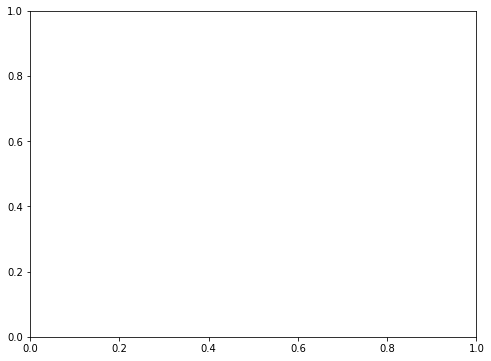

In [55]:
_, ax = plt.subplots(1, 1, figsize=(8, 6))

plot.kinetic_temperature_intervals(ax, metrics, sizes, mask=slice(None), ewma_alpha=0.9)

In [39]:
completed_df

,batch_size,batchnorm,bias_loc,bias_prior,bias_scale,burnin,cycles,data,depth,device,...,result.acc_stderr,result.lp_ensemble,result.lp_ensemble_std,result.lp_ensemble_stderr,result.lp_last,result.lp_mean,result.lp_std,result.lp_stderr,stop_time,fail_trace
4,125,True,0.0,gaussian,1.0,0,100,cifar10_augmented,20,try_cuda,...,0.002024,-0.311374,1.991838,0.199184,-0.278968,-0.312048,0.037571,0.003757,2020-11-19T12:45:06.481292,NaN
25,125,True,0.0,gaussian,1.0,0,100,cifar10_augmented,20,try_cuda,...,0.002056,-2.029171,0.285286,0.028529,-2.092324,-2.043392,0.178451,0.017845,2020-11-19T12:45:29.599738,NaN
37,125,True,0.0,gaussian,1.0,0,100,cifar10_augmented,20,try_cuda,...,0.001802,-0.280152,2.022944,0.202294,-0.259826,-0.280704,0.034090,0.003409,2020-11-19T13:21:34.627582,NaN
42,125,True,0.0,gaussian,1.0,0,100,cifar10_augmented,20,try_cuda,...,0.002532,-0.599681,1.704183,0.170418,-0.579725,-0.601122,0.055615,0.005561,2020-11-19T13:16:58.073090,NaN
56,125,True,0.0,gaussian,1.0,0,100,cifar10_augmented,20,try_cuda,...,0.001852,-0.288492,2.014668,0.201467,-0.265768,-0.289145,0.037552,0.003755,2020-11-19T13:19:50.438218,NaN


In [68]:
completed_df.sort_values("lr")

,batch_size,batchnorm,bias_loc,bias_prior,bias_scale,burnin,cycles,data,depth,device,...,result.acc_stderr,result.lp_ensemble,result.lp_ensemble_std,result.lp_ensemble_stderr,result.lp_last,result.lp_mean,result.lp_std,result.lp_stderr,stop_time,fail_trace
56,125,True,0.0,gaussian,1.0,0,100,cifar10_augmented,20,try_cuda,...,0.001852,-0.288492,2.014668,0.201467,-0.265768,-0.289145,0.037552,0.003755,2020-11-19T13:19:50.438218,NaN
37,125,True,0.0,gaussian,1.0,0,100,cifar10_augmented,20,try_cuda,...,0.001802,-0.280152,2.022944,0.202294,-0.259826,-0.280704,0.034090,0.003409,2020-11-19T13:21:34.627582,NaN
4,125,True,0.0,gaussian,1.0,0,100,cifar10_augmented,20,try_cuda,...,0.002024,-0.311374,1.991838,0.199184,-0.278968,-0.312048,0.037571,0.003757,2020-11-19T12:45:06.481292,NaN
42,125,True,0.0,gaussian,1.0,0,100,cifar10_augmented,20,try_cuda,...,0.002532,-0.599681,1.704183,0.170418,-0.579725,-0.601122,0.055615,0.005561,2020-11-19T13:16:58.073090,NaN
25,125,True,0.0,gaussian,1.0,0,100,cifar10_augmented,20,try_cuda,...,0.002056,-2.029171,0.285286,0.028529,-2.092324,-2.043392,0.178451,0.017845,2020-11-19T12:45:29.599738,NaN


In [106]:
full_df

,batch_size,batchnorm,bias_loc,bias_prior,bias_scale,burnin,cycles,data,depth,device,...,result.lp_last,result.lp_mean,result.lp_std,result.lp_stderr,start_time,status,stop_time,the_dir,result,fail_trace


array([ True, False, False, ..., False, False,  True])

(0.75, 1.0)

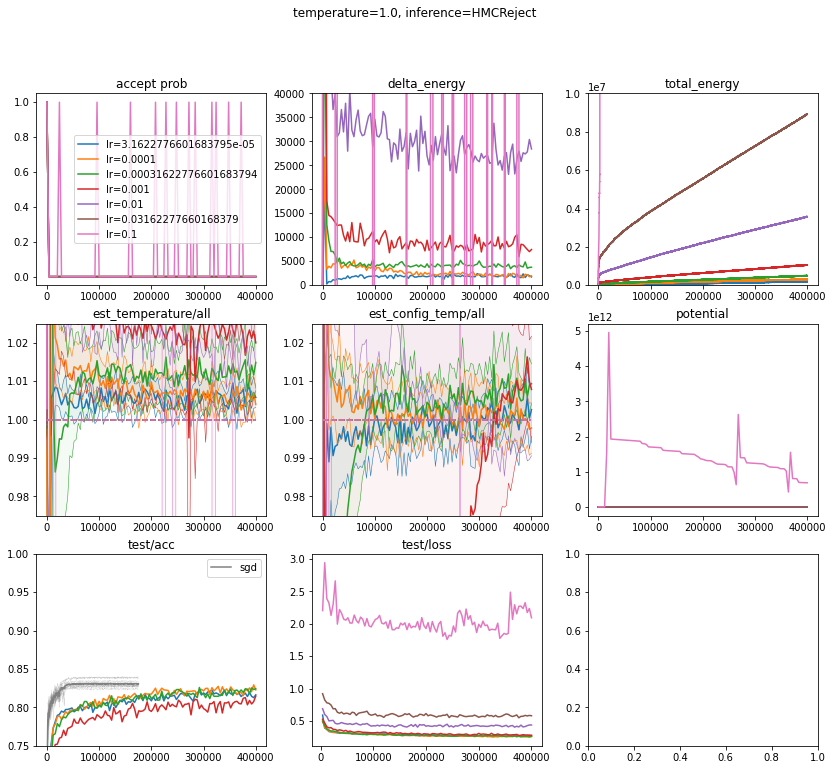

In [203]:
fig, axes = plt.subplots(3, 3, figsize=(14, 12), facecolor='white')


inference = "HMCReject"
temperature = 1.0

def accept_prob(x):
    return np.exp(np.minimum(0., -x/temperature))


completed_df = full_df[(full_df["weight_prior"] == "gaussian") 
                       & (full_df["temperature"] == temperature)
                       & (full_df["inference"] == inference)]

fig.suptitle(f"temperature={temperature}, inference={inference}")
for idx in completed_df.sort_values("lr").index:
    #if 0.1 != completed_df.loc[idx, "lr"]:
    #    continue
    plot_kwargs = dict(label=f"lr={completed_df.loc[idx, 'lr']}")
    with h5py.File(Path(completed_df.loc[idx, "the_dir"], "metrics.h5"), "r", swmr=True) as metrics:
        is_sample_mask = (metrics['acceptance/is_sample'][:] == 1)
        ax = axes[0, 0]
        plot.metric(ax, metrics, "delta_energy", transform=accept_prob,
                    plot_kwargs=plot_kwargs, mask=is_sample_mask)
        ax.set_title("accept prob")

        ax = axes[0, 1]
        plot.metric(ax, metrics, "delta_energy", mask=is_sample_mask, ewma_alpha=0.0, iqr_ylim=None,
                   plot_kwargs=plot_kwargs, legend=False)
        ax.set_title("delta_energy")

        #plot.vlines(axes[1], metrics, is_sample_mask)
        ax = axes[0, 2]
        plot.metric(ax, metrics, "total_energy", mask=slice(None), iqr_ylim=None, plot_kwargs=plot_kwargs, legend=False)
        ax.set_title("total_energy")
        
        ax = axes[1, 0]
        plot.temperature_stderr(ax, metrics, "est_temperature", sizes, mask=is_sample_mask, legend=False)
        ax.set_title("est_temperature/all")
        
        ax = axes[1, 1]
        plot.temperature_stderr(ax, metrics, "est_config_temp", sizes, mask=is_sample_mask, legend=False)
        ax.set_title("est_config_temp/all")
        
        
        ax = axes[1, 2]
        plot.metric(ax, metrics, "potential", mask=is_sample_mask, plot_kwargs=plot_kwargs, legend=False)
        ax.set_title("potential")
        
        ax = axes[2, 0]
        plot.metric(ax, metrics, "test/acc", mask=is_sample_mask, plot_kwargs=dict(label=None), legend=False)
        ax.set_title("test/acc")
        
        ax = axes[2, 1]
        plot.metric(ax, metrics, "test/loss", mask=is_sample_mask, plot_kwargs=plot_kwargs, legend=False)
        ax.set_title("test/loss")

        
axes[2, 0].plot(steps*(50000/128), np.mean(test_accs, 0), color="grey", label="sgd")
for ta in test_accs:
    axes[2, 0].plot(steps*(50000/128), ta, color="grey", linewidth=0.1)
axes[2, 0].legend()

        
axes[0, 1].set_ylim(-10, 40000)
axes[0, 2].set_ylim(-10, 10000000)
if temperature == 1.0:
    axes[1, 0].set_ylim(0.975, 1.025)
    axes[1, 1].set_ylim(0.975, 1.025)
elif temperature == 0.01:
    axes[1, 0].set_ylim(0.005, 0.02)
    axes[1, 1].set_ylim(0.004, 0.02)
axes[2, 0].set_ylim((0.75, 1.0))

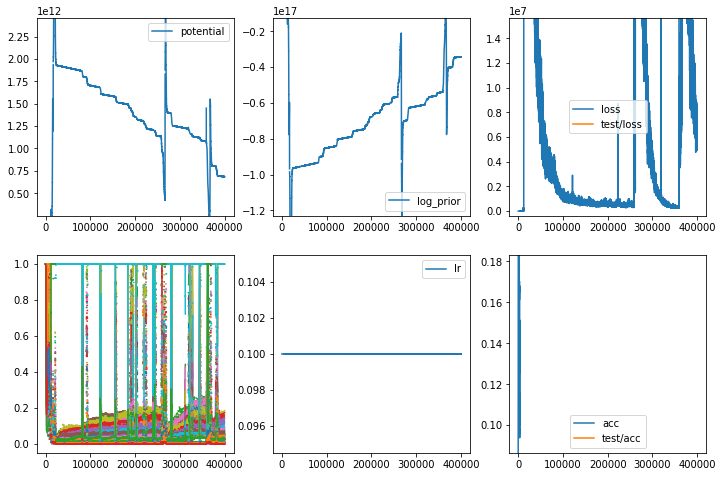

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

mask = slice(None)

plot.metric(axes[0, 0], metrics, 'potential', iqr_ylim=2., mask=mask)
plot.metric(axes[0, 1], metrics, 'log_prior', iqr_ylim=2., mask=mask)

test_mask = ~np.isnan(metrics["test/loss"])

plot.metric(axes[0, 2], metrics, 'loss', mask=mask, iqr_ylim=2.)
plot.metric(axes[0, 2], metrics, 'test/loss', mask=mask)

for k in metrics["preconditioner"].keys():
    plot.metric(axes[1, 0], metrics, "preconditioner/"+k, mask=mask, legend=False)

plot.metric(axes[1, 1], metrics, 'lr', mask=mask)

plot.metric(axes[1, 2], metrics, 'acc', mask=mask, iqr_ylim=2., ewma_alpha=0.9)
plot.metric(axes[1, 2], metrics, 'test/acc', mask=mask, iqr_ylim=2.)

In [14]:
"average acceptance", 1-np.mean(metrics["acceptance/rejected"][mask])

('average acceptance', 9.178023947533842e+18)

In [15]:
config

{'batch_size': 125,
 'batchnorm': True,
 'bias_loc': 0.0,
 'bias_prior': 'gaussian',
 'bias_prior_params': {},
 'bias_scale': 1.0,
 'burnin': 0,
 'cycles': 1000,
 'data': 'cifar10',
 'depth': 3,
 'device': 'try_cuda',
 'inference': 'VerletSGLDReject',
 'init_method': 'he',
 'load_samples': None,
 'log_dir': 'logs/cifar10_v2',
 'lr': 6e-05,
 'metrics_skip': 10,
 'model': 'googleresnet',
 'momentum': 1.0,
 'n_samples': 1000,
 'precond_update': 5,
 'progressbar': True,
 'reject_samples': False,
 'run_id': '880bec6f869047c59f1137b0b9a3ccb7',
 'sampling_decay': 'flat',
 'save_samples': True,
 'seed': 994413166,
 'skip': 1,
 'temperature': 1.0,
 'warmup': 4,
 'weight_loc': 0.0,
 'weight_prior': 'gaussian',
 'weight_prior_params': {},
 'weight_scale': 1.4142135623730951,
 'width': 50}

In [16]:
mcmc_burnin = 0

state_dict_samples = exp_utils.load_samples(log_dir/"samples.pt", idx=np.s_[mcmc_burnin:])
if config["reject_samples"]:
    # Making sure that rejected samples have the same value as the previous one
    print("made sure of rejected samples")
    exp_utils.reject_samples_(state_dict_samples, metrics)


## Load and poke the model

In [17]:
del state_dict_samples["steps"]
del state_dict_samples["timestamps"]

if device == torch.device("cpu") and config["device"] != "cpu":
    # HACK: get around the lack of `nn.DataParallel` when loading on CPU:
    # *remove* .module. from the key
    for k in list(state_dict_samples.keys()):
        if k.startswith("net.module."):
            state_dict_samples["net." + k.lstrip("net.module.")] = state_dict_samples[k]
            del state_dict_samples[k]

In [18]:
model.load_state_dict({k: v[-1] for k, v in state_dict_samples.items()})

<All keys matched successfully>